<strong><b><font size="5">Data Science Academy</font></b></strong>

<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Aula 19</font></b></strong>

<strong><b><font size="4">Prevendo a Média Mensal de Vendas - Otimização do Modelo SARIMA com Variável Exógena</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br

Uma maneira de melhorar o desempenho do modelo é adicionar uma variável exógena. Embora não seja garantia de melhoria, isso pode deixar o modelo mais preciso no forecast, pois mais um fator será considerado na previsão ao longo do tempo.

Uma variável exógena é uma variável que não está sendo sendo prevista na série. Por exemplo: se estamos prevendo o volume de vendas, uma variável que indica se o dia é feriado ou não, seria uma variável exógena. Aliás, é exatamente isso que vamos fazer.

Python possui um pacote de feriados (chamado holidays) que pode ser importado e usado para determinar se uma data foi ou não um feriado. O pacote tem os feriados do Brasil também. Mais detalhes logo abaixo.

O modelo SARIMAX que usamos até agora aceita variáveis exógenas como um argumento adicional. É o que faremos nesta aula. Acompanhe.

**Leia atentamente cada célula pois temos mudanças na Engenharia de Atributos e além disso nem tudo vai sair como o esperado. Mas posso garantir que o aprendizado será valioso.**

Boa aula.

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [0]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook, se necessário.

In [0]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [0]:
# Instala o plotly
!pip install -q plotly

In [0]:
# O comando abaixo instala o plotly-orca para gráficos interativos
# Se necessário, reinicie o Jupyter Notebook
# https://github.com/plotly/orca
# Não funciona no Google Colab, a menos que você instale o mini-conda no Google Colab. Pesquise sobre como fazer isso.
#!conda install -y -c plotly plotly-orca

In [0]:
# O statsmodels deve ser atualizado
!pip install -q -U statsmodels

     |████████████████████████████████| 8.7MB 2.8MB/s 


In [0]:
# Instala o pacote holidays
!pip install -q holidays

In [0]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
import holidays

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
matplotlib.style.use('ggplot')
%matplotlib inline

In [0]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

sklearn         0.22.2.post1
numpy           1.18.2
statsmodels.api 0.11.1
matplotlib      3.2.1
seaborn         0.10.0
statsmodels     0.11.1
scipy           1.4.1
holidays        0.9.12
plotly          4.4.1
pandas          1.0.3
Data Science Academy


## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [0]:
# Carrega os dados
dados = pd.read_csv('https://raw.githubusercontent.com/dsacademybr/Datasets/master/dataset6.csv')

In [0]:
# Shape
dados.shape

(9994, 21)

In [0]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [0]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [0]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [0]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [0]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [0]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [0]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [0]:
# Vamos checar os valores únicos por coluna (para ajudar a definir se a variável é categórica ou não)
for c in dados.columns:
    if len(set(dados[c])) < 20:
        print(c,set(dados[c]))

ship_mode {'Second Class', 'First Class', 'Standard Class', 'Same Day'}
segment {'Consumer', 'Home Office', 'Corporate'}
country {'United States'}
region {'East', 'West', 'Central', 'South'}
category {'Office Supplies', 'Technology', 'Furniture'}
sub_category {'Envelopes', 'Labels', 'Furnishings', 'Supplies', 'Storage', 'Phones', 'Copiers', 'Binders', 'Accessories', 'Chairs', 'Bookcases', 'Tables', 'Fasteners', 'Art', 'Appliances', 'Machines', 'Paper'}
quantity {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
discount {0.0, 0.8, 0.2, 0.3, 0.45, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15}


## E os Feriados?

Todas as vendas ocorrem nos EUA. Será que o fato de ser feriado de alguma forma contribui para a previsão de vendas? 

Não temos em nosso dataset nenhuma variável com esta informação e teremos que buscá-la externamente ao dataset. Em linhas gerais, isso é o que chamados de variável exógena.

De fato, teremos duas séries: uma com a data e a venda (que trabalhamos até aqui) e uma nova série com a data e a indicacão se aquela data foi feriado ou não. Vai dar um trabalhinho, mas é para isso que estamos aqui. Para resolver problemas. Vou mostrar tudo em detalhes para você.

E o interessante é que nem tudo vai sair como esperado! 

Vamos checar a primeira e última data de vendas.

In [0]:
# Primeira data de venda no dataset
dados['order_date'].min()

'2014-01-03'

In [0]:
# Última data de venda no dataset
dados['order_date'].max()

'2017-12-30'

Temos vendas do começo de 2014 ao fim de 2017. Vamos buscar os feriados nesse período.

O pacote holidays (que também permite coletar feriados do Brasil) torna nossa vida um pouco mais fácil. Observe:

In [0]:
# Vamos buscar todos os feriados nos EUA entre 2014 e 2017
for i, feriado in holidays.US(years = [2014, 2015, 2016, 2017]).items(): 
    print(i, feriado)

2016-01-01 New Year's Day
2016-01-18 Martin Luther King, Jr. Day
2016-02-15 Washington's Birthday
2016-05-30 Memorial Day
2016-07-04 Independence Day
2016-09-05 Labor Day
2016-10-10 Columbus Day
2016-11-11 Veterans Day
2016-11-24 Thanksgiving
2016-12-25 Christmas Day
2016-12-26 Christmas Day (Observed)
2017-01-01 New Year's Day
2017-01-02 New Year's Day (Observed)
2017-01-16 Martin Luther King, Jr. Day
2017-02-20 Washington's Birthday
2017-05-29 Memorial Day
2017-07-04 Independence Day
2017-09-04 Labor Day
2017-10-09 Columbus Day
2017-11-11 Veterans Day
2017-11-10 Veterans Day (Observed)
2017-11-23 Thanksgiving
2017-12-25 Christmas Day
2014-01-01 New Year's Day
2014-01-20 Martin Luther King, Jr. Day
2014-02-17 Washington's Birthday
2014-05-26 Memorial Day
2014-07-04 Independence Day
2014-09-01 Labor Day
2014-10-13 Columbus Day
2014-11-11 Veterans Day
2014-11-27 Thanksgiving
2014-12-25 Christmas Day
2015-01-01 New Year's Day
2015-01-19 Martin Luther King, Jr. Day
2015-02-16 Washington's

Hummm...muitos feriados. Foram 44 para ser exato. Vamos criar uma série para armazenar as datas dos feriados entre 2014 e 2017.

Para conhecer mais sobre o pacote holidays, acesse: https://pypi.org/project/holidays/

In [0]:
# Cria um dataframe vazio
feriados = pd.Series()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [0]:
# Vamos buscar todos os feriados nos EUA entre 2014 e 2017
for i, feriado in holidays.US(years = [2014, 2015, 2016, 2017]).items(): 
    feriados[i] = feriado

In [0]:
# Visualiza os dados
feriados.head(8)

2016-01-01                 New Year's Day
2016-01-18    Martin Luther King, Jr. Day
2016-02-15          Washington's Birthday
2016-05-30                   Memorial Day
2016-07-04               Independence Day
2016-09-05                      Labor Day
2016-10-10                   Columbus Day
2016-11-11                   Veterans Day
dtype: object

In [0]:
# Tipo
type(feriados)

pandas.core.series.Series

In [0]:
# Vamos converter a série em dataframe e fazer alguns ajustes
feriados_df = pd.DataFrame(feriados)

In [0]:
# Tipo
type(feriados_df)

pandas.core.frame.DataFrame

In [0]:
# Shape
feriados_df.shape

(44, 1)

In [0]:
# Reset do index para ajustar os nomes das colunas
feriados_df.reset_index(level = 0, inplace = True)

In [0]:
# Ajusta o nome das colunas
feriados_df.columns = ['data_feriado', 'feriado']

In [0]:
# Visualiza
feriados_df.head()

,data_feriado,feriado
0,2016-01-01,New Year's Day
1,2016-01-18,"Martin Luther King, Jr. Day"
2,2016-02-15,Washington's Birthday
3,2016-05-30,Memorial Day
4,2016-07-04,Independence Day


In [0]:
# Tipos de dados
feriados_df.dtypes

data_feriado    object
feriado         object
dtype: object

In [0]:
# Vamos deixar a coluna de data como tipo datetime, pois precisaremos disso daqui a pouco
feriados_df['data_feriado'] = pd.to_datetime(feriados_df['data_feriado'])

In [0]:
# Tipos de dados
feriados_df.dtypes

data_feriado    datetime64[ns]
feriado                 object
dtype: object

Perfeito. Já temos a série com os feriados.

Devemos adicionar ao nosso dataset agora? A resposta é não, pois não estamos usando o dataset inteiro, mas sim a média de vendas de produtos de tecnologia. Seria desperdício de recurso e de tempo adcionar agora.

Vamos preparar nossa série de média de vendas (como fizemos nas aulas anteriores) e aí sim adicionaremos a coluna com o feriado. Fique atento.

In [0]:
# Vamos checar as categorias de itens
#a = dados['category'].value_counts()
#fig = px.bar(a, x = a.index, y = a.values, height = 400)
#fig.update_layout(title = {'text': "Categorias de Itens", 
#                           'y':0.9,'x':0.5,'xanchor': 
#                           'center','yanchor': 'top'},
#                  xaxis_title = "Categoria",
#                  yaxis_title = "Total de Itens")
#fig.show(renderer = 'svg')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [0]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_tecnologia.head(3)

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales,quantity,discount,profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,California,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110


Agora vamos preparar as séries temporais.

In [0]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [0]:
# Como está ficando cada dataset?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [0]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [0]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

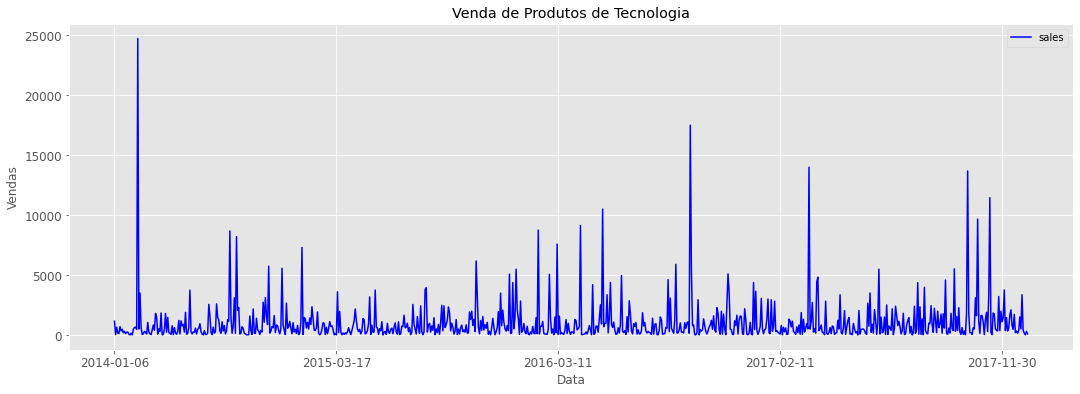

In [0]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [0]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [0]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [0]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [0]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
len(media_vendas_tecnologia)

48

In [0]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

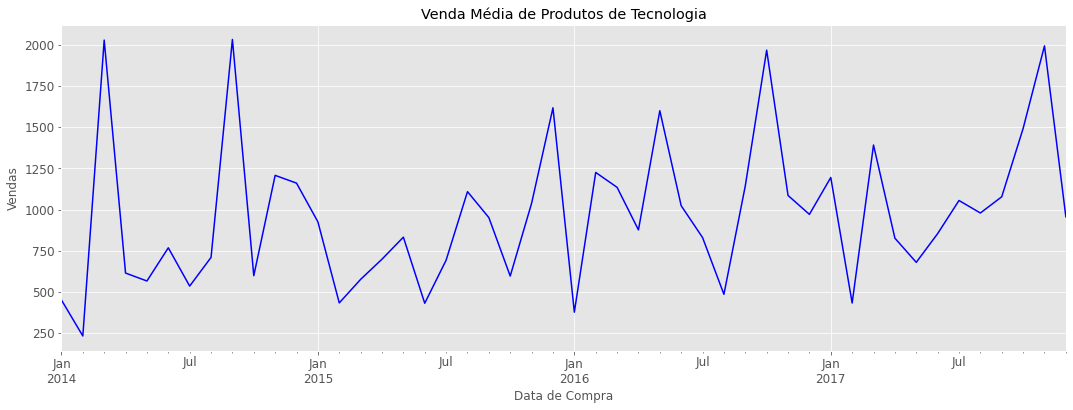

In [0]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

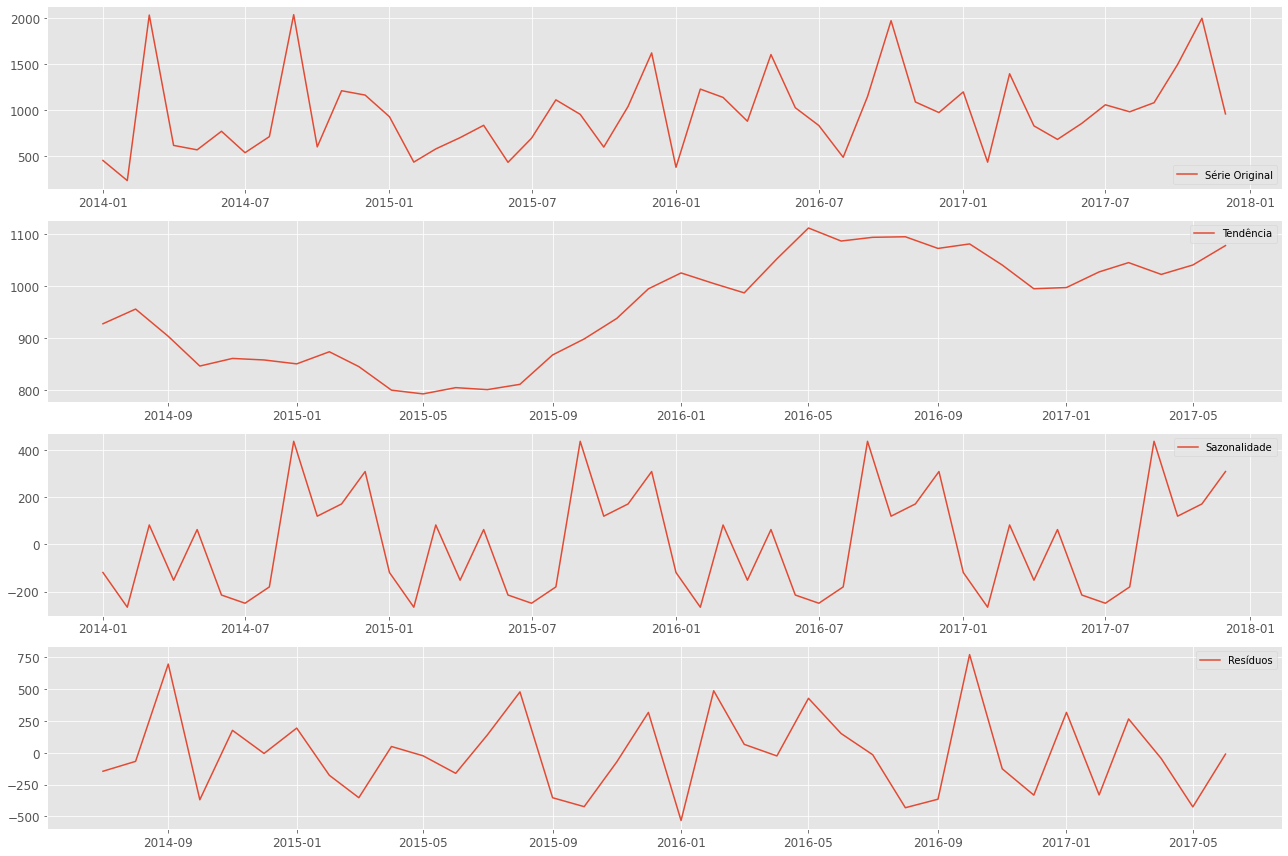

In [0]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [0]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

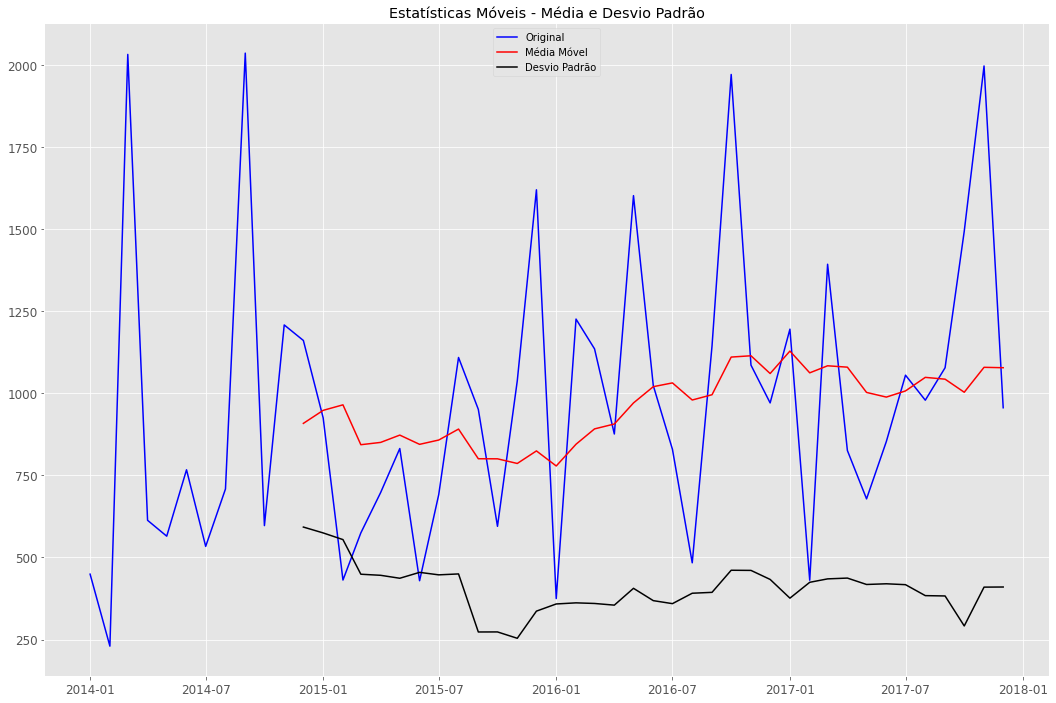


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [0]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Adicionando Feriado (Variável Exógena) a Nossa Série

Leia e compreenda a função abaixo. Não quero que você fique apenas executando código. Quero que você aprenda de verdade, mas você precisa fazer a sua parte.

A função abaixo compara as datas de dois dataframes, nossa série de vendas e nossa série de feriados. Quando a data for igual, preenchemos um vetor com 1 e quando for diferente preenchemos com 0. Simples, não? Criaremos uma variável categórica que será usada como variável exógena.

Mas teremos que converter nossa série em dataframe, fazer a operação e depois retornar para série. Se fosse fácil, qualquer um fazia, não é verdade? Por isso Cientistas de Dados são profissionais escassos no mercado.

Vamos fazer acontecer!

In [0]:
# Função
def adiciona_feriado(x):
    
    # Aplica a regra
    batch_df = feriados_df.apply(lambda y: 1 if (x['order_date'] == y['data_feriado']) else None, axis=1)
    
    # Limpa valores nulos
    batch_df = batch_df.dropna(axis = 0, how = 'all')  
    
    # Se estiver vazio, preenche com 0
    if batch_df.empty:
        batch_df = 0
    else: 
        batch_df = batch_df.to_string(index = False)
        
    return batch_df

In [0]:
# Confirma o tipo do objeto
type(media_vendas_tecnologia)

pandas.core.series.Series

In [0]:
# Cria um dataframe a partir da série
media_vendas_tecnologia_df = pd.DataFrame(media_vendas_tecnologia)

In [0]:
# Confirma o tipo do objeto
type(media_vendas_tecnologia_df)

pandas.core.frame.DataFrame

In [0]:
# Reset do índice para ajustar as colunas (podia ter feito tudo isso em um comando, ms didaticamente deixamos assim)
media_vendas_tecnologia_df.reset_index(level = 0, inplace = True)

In [0]:
# Ajusta o nome das colunas
media_vendas_tecnologia_df.columns = ['order_date', 'sales']

In [0]:
# Conferindo
media_vendas_tecnologia_df.head(3)

,order_date,sales
0,2014-01-01,449.041429
1,2014-02-01,229.787143
2,2014-03-01,2031.948375


In [0]:
# Tipos de dados
media_vendas_tecnologia_df.dtypes

order_date    datetime64[ns]
sales                float64
dtype: object

In [0]:
# Aplicamos a função e criamos a coluna feriado
media_vendas_tecnologia_df['feriado'] = media_vendas_tecnologia_df.apply(adiciona_feriado, axis = 1)

In [0]:
# Conferindo
media_vendas_tecnologia_df.head(3)

,order_date,sales,feriado
0,2014-01-01,449.041429,1.0
1,2014-02-01,229.787143,0
2,2014-03-01,2031.948375,0


Está ficando bonito. Mas não gostei do valor float em 1.0. Isso vai atraplhar meus planos. Temos solução para isso também.

In [0]:
# Convertendo a coluna feriado para inteiro
media_vendas_tecnologia_df['feriado'] = pd.to_numeric(media_vendas_tecnologia_df['feriado'], downcast = 'integer')

In [0]:
# Agora sim
media_vendas_tecnologia_df.head(3)

,order_date,sales,feriado
0,2014-01-01,449.041429,1
1,2014-02-01,229.787143,0
2,2014-03-01,2031.948375,0


In [0]:
# Vamos definir a order_date como índice
media_vendas_tecnologia_df.set_index("order_date", inplace = True)

In [0]:
# Mais um confere
media_vendas_tecnologia_df.head(3)

,sales,feriado
order_date,,
2014-01-01,449.041429,1
2014-02-01,229.787143,0
2014-03-01,2031.948375,0


In [0]:
# Vou deletar a série original
del media_vendas_tecnologia

In [0]:
# E recriá-la
media_vendas_tecnologia = media_vendas_tecnologia_df

In [0]:
# Voilá
media_vendas_tecnologia

,sales,feriado
order_date,,
2014-01-01,449.041429,1
2014-02-01,229.787143,0
2014-03-01,2031.948375,0
2014-04-01,613.028933,0
2014-05-01,564.698588,0
2014-06-01,766.905909,0
2014-07-01,533.608933,0
2014-08-01,708.435385,0
2014-09-01,2035.838133,1


Opa.

Tem algo estranho.

Perceba que a variável exógena aqui não vai funcionar como esperado, pois como nossa série é mensal, a data de venda é sempre o primeiro dia de cada mês e na prática, somente o dia 01 de Janeiro é feriado em cada ano. Para séries de médias mensais uma variáve exógena indicado feriado não parece adequada. Concorda? Claro que podemos trabalhar com a série original de vendas, mas aí estaríamos prevendo a série diária e não mensal.

Mas vamos seguir em frente pois quero mostrar algo interessante a você.

### Dividindo os Dados em Treino e Teste

In [0]:
# Divisão em treino e teste
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

In [0]:
len(trainset)

36

In [0]:
len(testset)

12

Precisamos de um passo adicional aqui, pois a variável exógena não pode ser incluída como variável de dados (simplesmente porque ela não é). O que queremos prever é o total em vendas e não os feriados, certo?

In [0]:
# Colocamos somente as vendas na série de dados
dados_treino = pd.Series(trainset['sales'])

In [0]:
# Observe o tipo deste objeto
type(dados_treino)

pandas.core.series.Series

In [0]:
# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_treino = sm.add_constant(trainset['feriado'])

In [0]:
# Observe o tipo deste objeto
type(exog_var_treino)

pandas.core.frame.DataFrame

In [0]:
# Observe os tipos de dados deste objeto
exog_var_treino.dtypes

const      float64
feriado       int8
dtype: object

In [0]:
# Conferindo os registros
exog_var_treino.head(3)

,const,feriado
order_date,,
2014-01-01,1.0,1
2014-02-01,1.0,0
2014-03-01,1.0,0


Embora sejam duas séries acima, para o processamento com o Statsmodels, a série de dados deve ficar como tipo série e a série da variável exógena deve ficar como dataframe, ou teremos erro no processamento. Vamos fazer o mesmo com os dados de teste.

In [0]:
# Colocamos somente as vendas na série de dados
dados_teste = pd.Series(testset['sales'])

In [0]:
# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_teste = sm.add_constant(testset['feriado'])

Ufa! Engenharia de Atributos não é lindo? 

Fique atento ao código abaixo e verifique onde incluímos as variáveis exógenas.

### Função Para o Cálculo da Acurácia

In [0]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

## Otimizando o Modelo SARIMA com Variável Exógena

Vamos manter a otimização com Grid Search que fizemos na aula 18 e acrescentar a variável exógena.

In [0]:
# Vamos definir p, d e q para que tenham valores entre 0 e 2 e testaremos as combinações.
p = d = q = range(0, 2)

Agora geramos diferentes combinações de p, d e q.

In [0]:
# Lista de combinações de p, d, q
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [0]:
# Lista de combinações dos hiperparâmetros sazonais P, D e Q
# Estamos usando List Comprehension
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [0]:
print('\nExemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:\n')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Exemplos de Combinações dos Hiperparâmetros Para o Modelo SARIMA:

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
# Grid Search
warnings.filterwarnings("ignore")

# Menor valor possível para a estatística AIC (nosso objetivo na otimização do modelo)
lowest_aic = sys.maxsize
lowest = ''

# Loop
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            # Cria o modelo com a combinação dos hiperparâmetros
            mod = sm.tsa.statespace.SARIMAX(dados_treino,
                                            exog_var_treino,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            
            # Treina o modelo
            results = mod.fit()
            
            # Print
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # Coleta o menor valor de AIC
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("\nModelo com Menor Valor de AIC: " + lowest)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:533.4308185633837
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:345.26757240308035
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:364.0768617188458
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:180.7908045248584
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:361.0882008235692
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:346.9050421597777
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:195.54049883217485
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:182.0875772933389
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:518.5675113657297
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:329.6541011671886
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:351.36523949742923
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:163.18307983883028
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:362.4747141947214
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:332.4120072764118
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:197.52806247393855
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:163.48234075654395
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:546.976725709374
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:337.8

In [0]:
# Treina o modelo com a melhor combinação de hiperparâmetros
modelo_sarima_v2 = sm.tsa.statespace.SARIMAX(dados_treino,
                                             exog_var_treino,
                                             order = (0, 1, 1),
                                             seasonal_order = (0, 1, 1, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility=False)

In [0]:
# Treinamento (Fit) do modelo
modelo_sarima_v2_fit = modelo_sarima_v2.fit()

In [0]:
# Sumário do modelo
print(modelo_sarima_v2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -69.830
Date:                            Sat, 18 Apr 2020   AIC                            149.659
Time:                                    10:10:56   BIC                            150.645
Sample:                                01-01-2014   HQIC                           147.531
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6155   1.98e+04     -0.000      1.000   -3.87e+04    3.87e+04
feriado     1287.5175   6051.891   

Perceba que tivemos um leve aumento de 3 pontos na estatística AIC. Não otimizamos o modelo, mas considerando que temos mais um elemento a mais para a previsão, a variável exógena, isso não parece ruim. Mas continue comigo.

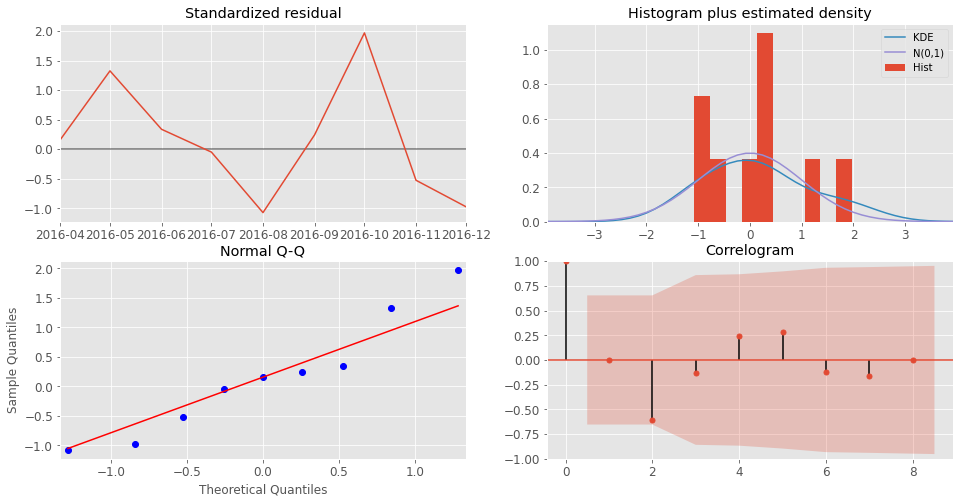

In [0]:
# Diagnóstico do modelo
modelo_sarima_v2_fit.plot_diagnostics(lags = 8, figsize = (16,8))
plt.show()

**Diagnóstico do Modelo:**

Assim como na Aula 18, o modelo segue com bons indicadores.

In [0]:
# Vamos fazer previsões um passo a frente
sarima_predict_2 = modelo_sarima_v2_fit.get_prediction(start = pd.to_datetime('2017-01-01'), 
                                                       end = pd.to_datetime('2017-12-01'),
                                                       exog = exog_var_teste,
                                                       dynamic = True)

In [0]:
# Intervalo de confiança
sarima_predict_conf_2 = sarima_predict_2.conf_int()
sarima_predict_conf_2

,lower sales,upper sales
2017-01-01,-209.449143,2066.538275
2017-02-01,-236.084543,2004.449136
2017-03-01,368.252703,2604.676148
2017-04-01,-84.480788,2151.819294
2017-05-01,144.685214,2380.984555
2017-06-01,-92.227995,2144.074202
2017-07-01,-148.866451,2087.438708
2017-08-01,-69.100403,2167.207725
2017-09-01,106.760021,2343.071191
2017-10-01,215.489273,2451.806074


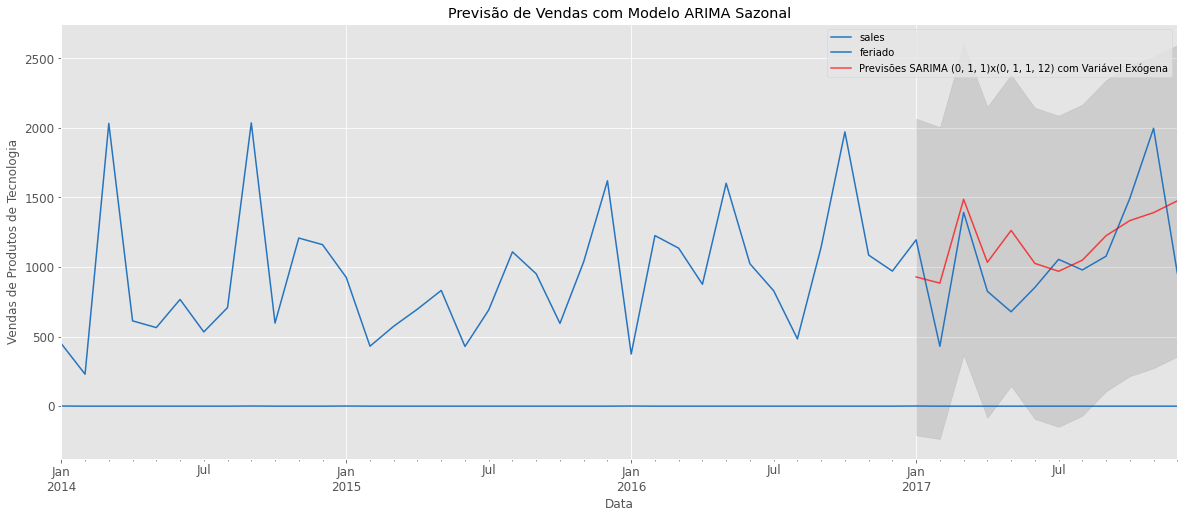

In [0]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_2.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 1, 1)x(0, 1, 1, 12) com Variável Exógena', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_2.index,
                # lower sales
                sarima_predict_conf_2.iloc[:, 0],
                # upper sales
                sarima_predict_conf_2.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Vendas com Modelo ARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

O modelo parece ter perdido um pouco do padrão da série.

In [0]:
# Calculando a performance
sarima_results = performance(dados_teste, sarima_predict_2.predicted_mean)
sarima_results

MSE das previsões é 116437.93
RMSE das previsões é 341.23
MAPE das previsões é 32.54


O erro do modelo reduziu em relação à versão da Aula 18. E agora? 

Vejamos como o modelo se sai em um horizonte de previsão maior.

Você percebeu que usamos a variável exógena no treino do modelo e na previsão do modelo. Percebeu, certo? Não? Então retorne às células anteriores e perceba!

Precisamos agora preparar a variável exógena para o forecast. Todas as variáveis usadas no treinamento do modelo tem que ser usadas em teste e agora no forecast. Assim como em qualquer modelo de Machine Learning.

In [0]:
# Vamos buscar todos os feriados nos EUA entre 2014 e 2017

# Cria a série
feriados_forecast = pd.Series()

# Busca os feriados
for i, feriado in holidays.US(years = [2017, 2018, 2019, 2020, 2021]).items(): 
    feriados_forecast[i] = feriado

In [0]:
len(feriados_forecast)

57

In [0]:
# Confere
feriados_forecast.tail()

2021-10-11                Columbus Day
2021-11-11                Veterans Day
2021-11-25                Thanksgiving
2021-12-25               Christmas Day
2021-12-24    Christmas Day (Observed)
dtype: object

In [0]:
# Vamos converter a série em dataframe e fazer alguns ajustes
feriados_forecast_df = pd.DataFrame(feriados_forecast)

# Reset do index para ajustar os nomes das colunas
feriados_forecast_df.reset_index(level = 0, inplace = True)

# Ajusta o nome das colunas
feriados_forecast_df.columns = ['data_feriado', 'feriado']

# Vamos converter a coluna de data para o tipo de correto
feriados_forecast_df['data_feriado'] = pd.to_datetime(feriados_forecast_df['data_feriado'])

# Vamos definir a data como índice
feriados_forecast_df.set_index("data_feriado", inplace = True)

# Não sabemos o dia que vai ter venda (é o que queremos prever), então vamos colocar zero em 
feriados_forecast_df['feriado'] = 0

# Convertendo a coluna feriado para inteiro
feriados_forecast_df['feriado'] = pd.to_numeric(feriados_forecast_df['feriado'], downcast = 'integer')

# E somente o feriado (mais uma constante requerida pelo statsmodels) na série de feriado
exog_var_forecast = sm.add_constant(feriados_forecast_df['feriado'])
exog_var_forecast['feriado'] = 1

In [0]:
exog_var_forecast.head(3)

,const,feriado
data_feriado,,
2017-01-01,1.0,1
2017-01-02,1.0,1
2017-01-16,1.0,1


In [0]:
# Forecast (previsão) de 60 passos no tempo (na prática vamos reduzir para 57 pois só temos 57 feriados)
horizonte_60_predict_2 = modelo_sarima_v2_fit.get_forecast(steps = 57, exog = exog_var_forecast, dynamic = True)

In [0]:
# Intervalo de confiança
horizonte_60_predict_2_conf_2 = horizonte_60_predict_2.conf_int()
horizonte_60_predict_2_conf_2

,lower sales,upper sales
2017-01-01,-209.449143,2066.538275
2017-02-01,1051.432955,3291.966633
2017-03-01,1655.770200,3892.193646
2017-04-01,1203.036710,3439.336792
2017-05-01,1432.202712,3668.502052
2017-06-01,1195.289502,3431.591699
2017-07-01,1138.651046,3374.956206
2017-08-01,1218.417095,3454.725222
2017-09-01,1394.277518,3630.588689
2017-10-01,1503.006771,3739.323571


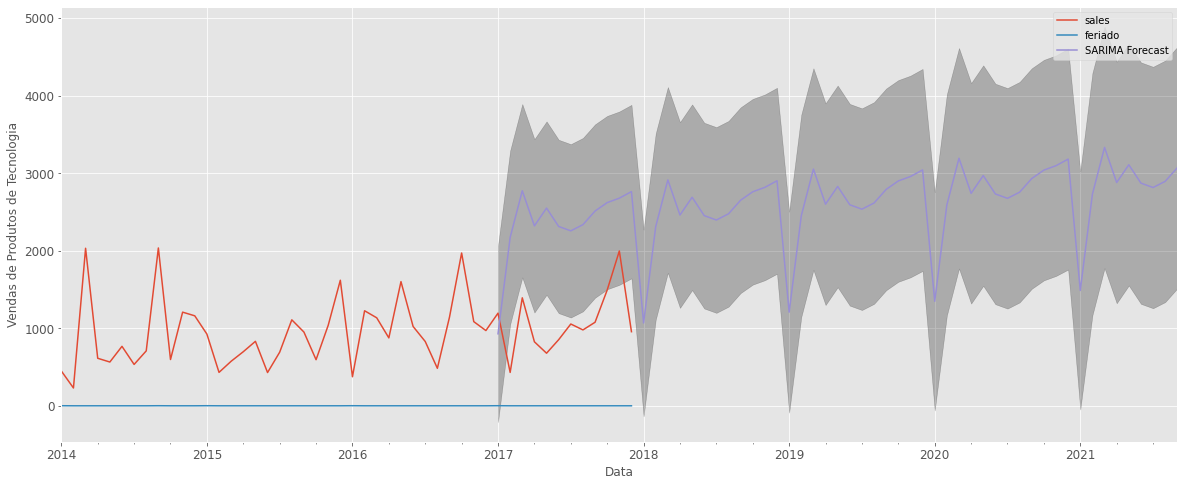

In [0]:
rcParams['figure.figsize'] = 20,8

# Plot dos valores observados
ax = media_vendas_tecnologia.plot(label = 'Valores Observados')

# Plot dos valores previstos
horizonte_60_predict_2.predicted_mean.plot(ax = ax, label = 'SARIMA Forecast')

# Plot do intervalo de confiança
ax.fill_between(horizonte_60_predict_2_conf_2.index,
                horizonte_60_predict_2_conf_2.iloc[:, 0],
                horizonte_60_predict_2_conf_2.iloc[:, 1], color = 'k', alpha = .25)

# Plot
ax.set_xlabel('Data')
ax.set_ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

E aí está o problema! 

Nosso modelo tem um desempenho ruim ao longo do tempo. Isso se explica porque a previsão de vendas é uma média mensal e o feriado não pode ser considerado pelo modelo. Esses picos para baixo são os feriados do dia 01 de janeiro de cada ano, quando a venda é menor. Mas com essa variável exógena o modelo acaba se perdendo na previsão do padrão da série, que é que interessa.

Veja como também aprendemos quando as coisas não saem como esperado. Por isso a experimentação é tão importante em Ciência de Dados.

In [0]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v2_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.49095878]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

No geral, o modelo até tenta fazer as previsões, pois o modelo SARIMA é poderoso, mas a variável exógena aqui está atrapalhando mais do que ajudando.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA (1,1) - AIC = 550.3 e RMSE = 420.2
- Aula 16 --> Modelo ARIMA (6,0,2) - AIC = 559.4 e RMSE = 401.5
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12)  - AIC = 176.74 e RMSE = 425.89
- Aula 18 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12)  - AIC = 146.77 e RMSE = 353.57
- Aula 19 --> Modelo SARIMA(1, 1, 0)x(1, 1, 0, 12) com exog  - AIC = 149.66 e RMSE = 341.23

Aqui chegamos a um dilema comum em séries temporais. Se você estivesse analisando apenas as métricas, escolheria entre os modelos das aulas 18 ou 19? Menor AIC ou menor RMSE? Conforme já conversamos, o RMSE indica a performance do modelo com os dados do dataset e o AIC indica a performance do modelo no forecast, que é o que interessa.

Dos 4 modelos acima, o modelo da Aula 18 é o que deveria ser escolhido como modelo final considerando a família ARIMA.

Agora vamos trocar de modelo. Até a Aula 20.

# Fim